# Testing on our own images

Using device: cpu


C:\Users\PC\AppData\Local\Temp\ipykernel_5372\2676553002.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_weights_path)


Pretrained weights loaded successfully.


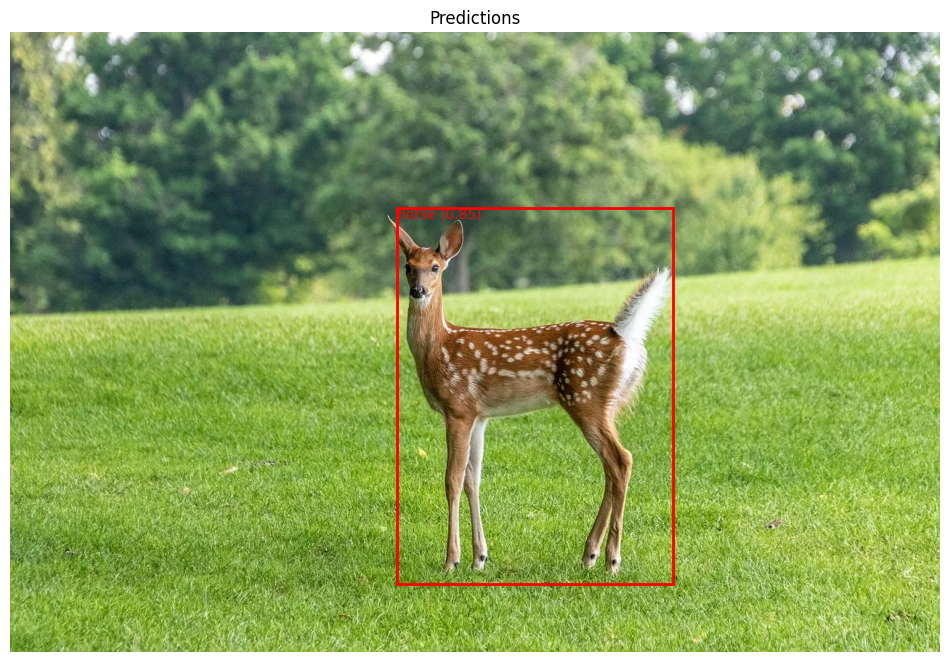

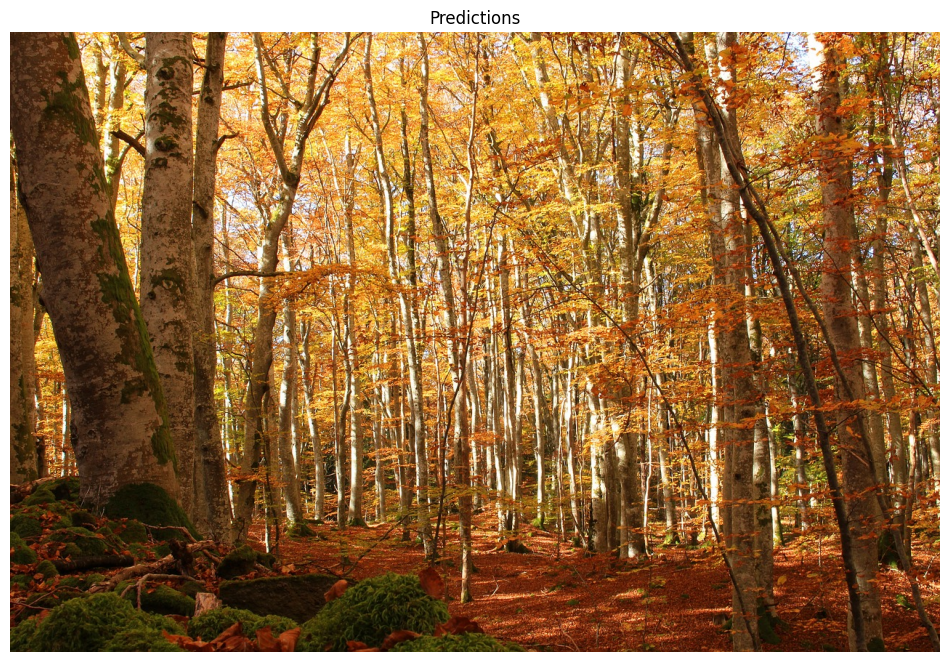

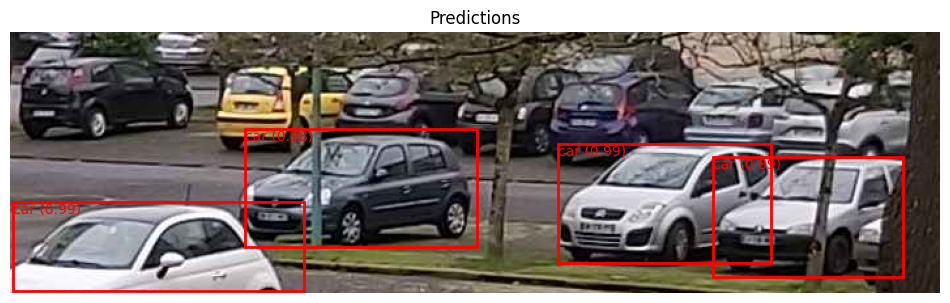

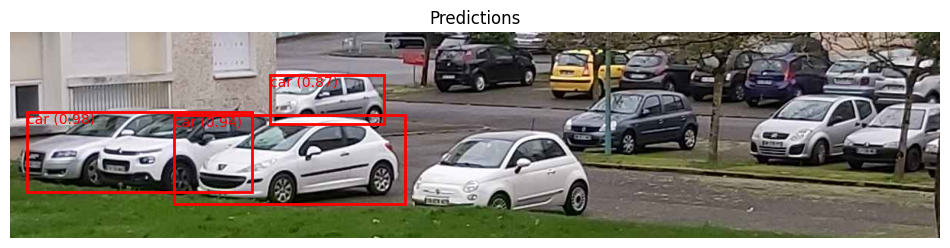

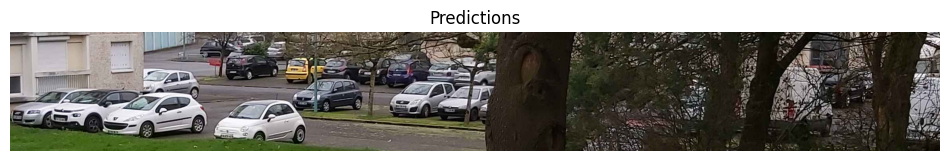

In [3]:
# Load and preprocess a custom image (no labels required)
from PIL import Image
import torchvision.transforms as T
import os
import torch
import matplotlib.pyplot as plt
import model
import json


device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else
                      "cpu")
print(f"Using device: {device}")

with open("classes.json", "r") as f:
    class_map = json.load(f)


model = model.SSD()

pretrained_weights_path = "./detection_weights.pth"

try:
    state_dict = torch.load(pretrained_weights_path)
    model.load_state_dict(state_dict)
    print("Pretrained weights loaded successfully.")
except FileNotFoundError:
    print("Pretrained weights file not found. Using random initialization.")
except Exception as e:
    print(f"Error loading pretrained weights: {e}")

model.to(device)
model.eval()

# Visualize predictions
def visualize_predictions_no_label(images, outputs, class_map, threshold=0.8):
    for img, output in zip(images, outputs):
        fig, ax = plt.subplots(1, figsize=(12, 12))
        img = img.permute(1, 2, 0).cpu().numpy()  # Convert from CxHxW to HxWxC
        ax.imshow(img)

        # Plot predicted bounding boxes and labels
        for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
            if score > threshold:  # Show high-confidence predictions
                xmin, ymin, xmax, ymax = box.cpu().numpy()
                label_name = class_map[str(label.item())]  # Get label name from class_map
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin, f"{label_name} ({score:.2f})", color='r', fontsize=10, verticalalignment='top')

        plt.axis('off')
        plt.title("Predictions")
        plt.show()



# Visualize the predictions for the whole folder
folder_path = "./our_data/"
for image_name in os.listdir(folder_path):
    #pass if the file is not an image
    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg','webp')):
        continue
    image_path = os.path.join(folder_path, image_name)
    image = Image.open(image_path)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
    visualize_predictions_no_label([image_tensor[0].cpu()], [outputs[0]], class_map, threshold=0.8)